# Parkzap Labs Machine Learning Associate Task


# TO DO 

1. Switch to validation metrics form of model
2. Evaluate, Try increasing image dimensions (Image size 150 * 150, 200 * 200 goes out of memory on 750ti), more data ?
3. Write report
4. Check performance on resnet version

# Preparing Dataset 
Preparing classes, labels, training test sets.

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm    # for progress meter in loop


REBUILD_DATA = True   # Set to false if you don't want to rebuild train, test sets for each execution. 

class SwiftVsInnova():
    IMG_SIZE = 120
    Swift = "CarImages/Swift"
    Innova = "CarImages/Innova"
    labels = {Swift : 0, Innova : 1}    
    training_data = []
    swiftcount = 0
    innovacount = 0
    
    def Make_Training_Data(self) :
        for label in self.labels :
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.labels[label]]])
                        
                        if label == self.Swift:
                            self.swiftcount +=1
                        elif label == self.Innova:
                            self.innovacount +=1
                    except Exception as e:
                        pass
                        #print(str(e))
                
        np.random.shuffle(self.training_data)
        np.save("Car_classifier_data_120_val.npy", self.training_data)
        # To check balance of data in terms of target variables.
        print("Innova Count :", self.innovacount)
        print("Swift Count :", self.swiftcount)

if REBUILD_DATA:
    swiftvinnova = SwiftVsInnova()
    swiftvinnova.Make_Training_Data()


  4%|▎         | 38/1068 [00:00<00:02, 367.21it/s]

CarImages/Swift


  2%|▏         | 20/1014 [00:00<00:09, 109.83it/s]

CarImages/Innova


100%|██████████| 1014/1014 [00:04<00:00, 247.87it/s]

Innova Count : 1001
Swift Count : 1037


In [2]:
training_data = np.load("Car_classifier_data_120_val.npy", allow_pickle=True)
print(len(training_data))
print(training_data[0][0])

2038
[[ 50  43  47 ...  52  23  38]
 [ 41  45  50 ...  74  70  37]
 [ 44  46  50 ...  79  83  30]
 ...
 [246 246 248 ... 219 205 234]
 [243 245 246 ... 157 172 186]
 [225 215 218 ... 166 173 196]]


566


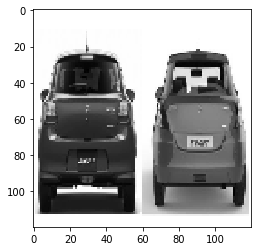

[1. 0.]


In [3]:
import matplotlib.pyplot as plt
num = np.random.randint(1291)
print(num)
plt.imshow(training_data[num][0], cmap = "gray")
plt.show()
print(training_data[num][1]) 

# Building the Model/Passing data in feed forward 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.core.debugger import set_trace # For debugging in Python

# Selecting whether to run on GPU (if available) or CPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

class Net(nn.Module) :
    def __init__(self) :
        super().__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.conv1 = nn.Conv2d(1, 32, 5)
        # Output of first conv layer : O = { (W - k + 2*P)/s } + 1, Initially image size, W = 28
        # Kernel Size, k = 5    Stride , s = 1  Padding, P = 0
        # in our case W =50, k = 5, s = 1, so O1 = (50-5 + 0)/1 + 1 = 46 for first conv2d output
        self.conv2 = nn.Conv2d(32, 64, 5)
        # here O = { (W - k + 2*P)/s } + 1, But first the output of conv1 will run through a maxpool so,it gets complicated 
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        # We dont know input shape into First linear layer after passing through convolution layers. 
        # It can be calculated or follow the method in video
        
        # Passing random data x 
        
        #set_trace() # Set trace for debugging value of X
        x = torch.randn(120,120).view(-1,1,120,120)
        self._to_linear = None
        self.convs(x)   # Partial forward pass
        
        self.fc1 = nn.Linear(self._to_linear, 512) # Flattening , from calculation should be 2*2, 4
        self.fc2 = nn.Linear(512, 2)   # Output 2 because we're doing 2 classes
    def convs(self, x):           # Passing data through conv, using Relu activation and maxpool layer 
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,(2,2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,(2,2))
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,(2,2))
        # Print shape of Tensor after passing through convs, 
        # print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
 # Feed forward propogation   
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
net = Net().to(device)
print(net)

Running on the GPU
Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=15488, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


# Calculating output of pass through cov, maxpool and input dimension of FC

The input image is 50 * 50, so:
O1 = (50-5+2*0)/1 + 1=46
O1 max pooling = (46)/2 = 23
O2 = (23-5+2*0)/1 + 1 = 19
O2 max pooling = (19)/2 = 8.5 # O2 max pooling = (18)/2 = 9
O3 = (8.5-5+2*0)/1 + 1 = 4.5  # O3 = (9-5+2*0)/1 +1 = 5
O3 max pooling = 4.5=2.25     # O3 max pooling = 4/2 = 2

We cannot have output/input shapes as decimal numbers (Just think about how can we represent 0.5 pixel as?). PyTorch like Keras/TensorFlow probably handles it by simple cropping the last column of pixels off. So for layer "02 max pooling" in your case, PyTorch will consider 18 columns only (so 18/2 = 9 and subsequent calculations are again similar). Paddings are generally added to handle such cases.

# Training - Loss and Optimizing parameters
Passing the Training data through the Model and calculating loss (Mean Squared Error). Then using Adam optimizer to adjust parameters/weights of the model.

In [5]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr = .001)  #Passing model to optimizer and setting Learning rate
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 120, 120)
X = X/255.0    # Pixel values are between 0 and 255, to transform to 0 - 1 range
y = torch.Tensor([i[1] for i in training_data])

# Creating validation set/ Test set
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT) # coverting to int as it will be used as a number to slice with
print(val_size)

203


In [6]:
train_X = X[:-val_size]
train_y = y[:-val_size]
test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

1835
203


In [7]:
# new Forward pass function 

def fwd_pass(X, y, train=False):

    if train:
        net.zero_grad()
    outputs = net(X)
    # addition that compares the argmax of the vectors, zip for list comprehension 
    matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
    # Accuracy percentage in sample
    #(IN SAMPLE ACCURACY WHILE TRAINING)
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()

    return acc, loss



In [8]:
def test(size=32):
    X, y = test_X[:size], test_y[:size]
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 120, 120).to(device), y.to(device))
    return val_acc, val_loss

val_acc, val_loss = test(size=32)
print(val_acc, val_loss)

0.53125 tensor(0.2493, device='cuda:0', grad_fn=<MseLossBackward>)


In [9]:
import time

MODEL_NAME = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time. 
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)
def train(net):
    BATCH_SIZE = 50
    EPOCHS = 20

    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,120,120)
                batch_y = train_y[i:i+BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")
                #f.write(f"{MODEL_NAME},{round(time.time(),3)},train,{round(float(acc),2)},{round(float(loss),4)}\n")
                # just to show the above working, and then get out:
                if i % 50 == 0:
                    val_acc, val_loss = test(size=32)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)},{epoch}\n")
train(net)

  3%|▎         | 1/37 [00:00<00:05,  6.09it/s]

model-1579336059
Acc: 0.3  Loss: 0.2544


  8%|▊         | 3/37 [00:00<00:05,  6.28it/s]

Acc: 0.56  Loss: 0.3489
Acc: 0.6  Loss: 0.2431


 14%|█▎        | 5/37 [00:00<00:04,  6.48it/s]

Acc: 0.4  Loss: 0.2551
Acc: 0.58  Loss: 0.2481


 19%|█▉        | 7/37 [00:01<00:04,  6.63it/s]

Acc: 0.38  Loss: 0.258
Acc: 0.46  Loss: 0.2516


 24%|██▍       | 9/37 [00:01<00:04,  6.69it/s]

Acc: 0.44  Loss: 0.251
Acc: 0.52  Loss: 0.2496


 30%|██▉       | 11/37 [00:01<00:03,  6.68it/s]

Acc: 0.54  Loss: 0.2498
Acc: 0.48  Loss: 0.2522


 35%|███▌      | 13/37 [00:01<00:03,  6.69it/s]

Acc: 0.56  Loss: 0.2491
Acc: 0.42  Loss: 0.2516


 41%|████      | 15/37 [00:02<00:03,  6.75it/s]

Acc: 0.5  Loss: 0.2503
Acc: 0.48  Loss: 0.2503


 46%|████▌     | 17/37 [00:02<00:02,  6.77it/s]

Acc: 0.5  Loss: 0.2499
Acc: 0.5  Loss: 0.25


 51%|█████▏    | 19/37 [00:02<00:02,  6.72it/s]

Acc: 0.5  Loss: 0.2498
Acc: 0.48  Loss: 0.2504


 57%|█████▋    | 21/37 [00:03<00:02,  6.61it/s]

Acc: 0.54  Loss: 0.2488
Acc: 0.48  Loss: 0.2501


 62%|██████▏   | 23/37 [00:03<00:02,  6.41it/s]

Acc: 0.6  Loss: 0.2471
Acc: 0.54  Loss: 0.2481


 68%|██████▊   | 25/37 [00:03<00:01,  6.50it/s]

Acc: 0.54  Loss: 0.2479
Acc: 0.56  Loss: 0.244


 73%|███████▎  | 27/37 [00:04<00:01,  6.58it/s]

Acc: 0.42  Loss: 0.2632
Acc: 0.44  Loss: 0.26


 78%|███████▊  | 29/37 [00:04<00:01,  6.55it/s]

Acc: 0.58  Loss: 0.2445
Acc: 0.54  Loss: 0.2476


 84%|████████▍ | 31/37 [00:04<00:00,  6.42it/s]

Acc: 0.54  Loss: 0.2468
Acc: 0.44  Loss: 0.2528


 89%|████████▉ | 33/37 [00:05<00:00,  6.38it/s]

Acc: 0.34  Loss: 0.2534
Acc: 0.56  Loss: 0.249


 95%|█████████▍| 35/37 [00:05<00:00,  6.30it/s]

Acc: 0.62  Loss: 0.2495
Acc: 0.56  Loss: 0.2499


  0%|          | 0/37 [00:00<?, ?it/s]

Acc: 0.56  Loss: 0.2498
Acc: 0.51  Loss: 0.2498


  5%|▌         | 2/37 [00:00<00:05,  6.66it/s]

Acc: 0.7  Loss: 0.2492
Acc: 0.56  Loss: 0.2496


 11%|█         | 4/37 [00:00<00:04,  6.69it/s]

Acc: 0.6  Loss: 0.2493
Acc: 0.4  Loss: 0.2509


 16%|█▌        | 6/37 [00:00<00:04,  6.71it/s]

Acc: 0.42  Loss: 0.2509
Acc: 0.62  Loss: 0.2487


 22%|██▏       | 8/37 [00:01<00:04,  6.54it/s]

Acc: 0.54  Loss: 0.2492
Acc: 0.56  Loss: 0.2485


 27%|██▋       | 10/37 [00:01<00:04,  6.38it/s]

Acc: 0.52  Loss: 0.2506
Acc: 0.54  Loss: 0.2468


 32%|███▏      | 12/37 [00:01<00:03,  6.38it/s]

Acc: 0.48  Loss: 0.2527
Acc: 0.56  Loss: 0.2474


 38%|███▊      | 14/37 [00:02<00:03,  6.69it/s]

Acc: 0.42  Loss: 0.2527
Acc: 0.5  Loss: 0.2494


 43%|████▎     | 16/37 [00:02<00:03,  6.85it/s]

Acc: 0.48  Loss: 0.2503
Acc: 0.5  Loss: 0.25


 49%|████▊     | 18/37 [00:02<00:02,  6.94it/s]

Acc: 0.5  Loss: 0.2501
Acc: 0.5  Loss: 0.2498


 54%|█████▍    | 20/37 [00:03<00:02,  6.62it/s]

Acc: 0.52  Loss: 0.2498
Acc: 0.46  Loss: 0.2503


 59%|█████▉    | 22/37 [00:03<00:02,  6.42it/s]

Acc: 0.52  Loss: 0.2497
Acc: 0.4  Loss: 0.2513


 65%|██████▍   | 24/37 [00:03<00:01,  6.53it/s]

Acc: 0.46  Loss: 0.2502
Acc: 0.46  Loss: 0.2501


 70%|███████   | 26/37 [00:03<00:01,  6.77it/s]

Acc: 0.54  Loss: 0.2494
Acc: 0.56  Loss: 0.2487


 76%|███████▌  | 28/37 [00:04<00:01,  6.90it/s]

Acc: 0.52  Loss: 0.2503
Acc: 0.62  Loss: 0.247


 81%|████████  | 30/37 [00:04<00:01,  6.96it/s]

Acc: 0.54  Loss: 0.2466
Acc: 0.56  Loss: 0.241


 86%|████████▋ | 32/37 [00:04<00:00,  6.59it/s]

Acc: 0.44  Loss: 0.2715
Acc: 0.34  Loss: 0.2674


 92%|█████████▏| 34/37 [00:05<00:00,  6.63it/s]

Acc: 0.5  Loss: 0.2491
Acc: 0.46  Loss: 0.2521


 97%|█████████▋| 36/37 [00:05<00:00,  6.82it/s]

Acc: 0.56  Loss: 0.2446
Acc: 0.5  Loss: 0.2484


  3%|▎         | 1/37 [00:00<00:05,  6.40it/s]

Acc: 0.54  Loss: 0.2474
Acc: 0.68  Loss: 0.2396


  8%|▊         | 3/37 [00:00<00:05,  6.31it/s]

Acc: 0.56  Loss: 0.2419
Acc: 0.6  Loss: 0.239


 14%|█▎        | 5/37 [00:00<00:04,  6.53it/s]

Acc: 0.4  Loss: 0.2672
Acc: 0.42  Loss: 0.2583


 19%|█▉        | 7/37 [00:01<00:04,  6.38it/s]

Acc: 0.6  Loss: 0.2454
Acc: 0.6  Loss: 0.2445


 24%|██▍       | 9/37 [00:01<00:04,  6.33it/s]

Acc: 0.64  Loss: 0.2452
Acc: 0.56  Loss: 0.246


 30%|██▉       | 11/37 [00:01<00:03,  6.66it/s]

Acc: 0.64  Loss: 0.246
Acc: 0.58  Loss: 0.2457


 35%|███▌      | 13/37 [00:01<00:03,  6.72it/s]

Acc: 0.5  Loss: 0.2519
Acc: 0.68  Loss: 0.2434


 41%|████      | 15/37 [00:02<00:03,  6.46it/s]

Acc: 0.62  Loss: 0.2425
Acc: 0.58  Loss: 0.2422


 46%|████▌     | 17/37 [00:02<00:03,  6.56it/s]

Acc: 0.58  Loss: 0.244
Acc: 0.54  Loss: 0.2493


 51%|█████▏    | 19/37 [00:02<00:02,  6.50it/s]

Acc: 0.58  Loss: 0.2381
Acc: 0.44  Loss: 0.2516


 57%|█████▋    | 21/37 [00:03<00:02,  6.76it/s]

Acc: 0.66  Loss: 0.2284
Acc: 0.58  Loss: 0.2406


 62%|██████▏   | 23/37 [00:03<00:02,  6.61it/s]

Acc: 0.62  Loss: 0.2422
Acc: 0.62  Loss: 0.2345


 68%|██████▊   | 25/37 [00:03<00:01,  6.65it/s]

Acc: 0.58  Loss: 0.2503
Acc: 0.62  Loss: 0.2222


 73%|███████▎  | 27/37 [00:04<00:01,  6.43it/s]

Acc: 0.7  Loss: 0.2264
Acc: 0.6  Loss: 0.2327


 78%|███████▊  | 29/37 [00:04<00:01,  6.35it/s]

Acc: 0.5  Loss: 0.2822
Acc: 0.54  Loss: 0.2432


 84%|████████▍ | 31/37 [00:04<00:00,  6.53it/s]

Acc: 0.64  Loss: 0.2215
Acc: 0.48  Loss: 0.2522


 89%|████████▉ | 33/37 [00:05<00:00,  6.76it/s]

Acc: 0.5  Loss: 0.2565
Acc: 0.58  Loss: 0.2313


 95%|█████████▍| 35/37 [00:05<00:00,  6.86it/s]

Acc: 0.7  Loss: 0.2208
Acc: 0.62  Loss: 0.232


  0%|          | 0/37 [00:00<?, ?it/s]

Acc: 0.62  Loss: 0.2368
Acc: 0.57  Loss: 0.2332


  5%|▌         | 2/37 [00:00<00:05,  6.70it/s]

Acc: 0.66  Loss: 0.2294
Acc: 0.7  Loss: 0.2138


 11%|█         | 4/37 [00:00<00:05,  6.45it/s]

Acc: 0.62  Loss: 0.2246
Acc: 0.54  Loss: 0.2348


 16%|█▌        | 6/37 [00:00<00:04,  6.39it/s]

Acc: 0.62  Loss: 0.2116
Acc: 0.58  Loss: 0.2404


 22%|██▏       | 8/37 [00:01<00:04,  6.60it/s]

Acc: 0.76  Loss: 0.1906
Acc: 0.54  Loss: 0.243


 27%|██▋       | 10/37 [00:01<00:03,  6.80it/s]

Acc: 0.68  Loss: 0.1945
Acc: 0.72  Loss: 0.2013


 32%|███▏      | 12/37 [00:01<00:03,  6.91it/s]

Acc: 0.62  Loss: 0.2185
Acc: 0.64  Loss: 0.2372


 38%|███▊      | 14/37 [00:02<00:03,  6.91it/s]

Acc: 0.72  Loss: 0.1793
Acc: 0.66  Loss: 0.2228


 43%|████▎     | 16/37 [00:02<00:03,  6.73it/s]

Acc: 0.74  Loss: 0.1974
Acc: 0.62  Loss: 0.2386


 49%|████▊     | 18/37 [00:02<00:02,  6.45it/s]

Acc: 0.74  Loss: 0.1753
Acc: 0.66  Loss: 0.1965


 54%|█████▍    | 20/37 [00:03<00:02,  6.58it/s]

Acc: 0.7  Loss: 0.2031
Acc: 0.72  Loss: 0.2024


 59%|█████▉    | 22/37 [00:03<00:02,  6.78it/s]

Acc: 0.78  Loss: 0.1591
Acc: 0.66  Loss: 0.2075


 65%|██████▍   | 24/37 [00:03<00:01,  6.88it/s]

Acc: 0.7  Loss: 0.2018
Acc: 0.68  Loss: 0.2347


 70%|███████   | 26/37 [00:03<00:01,  6.94it/s]

Acc: 0.7  Loss: 0.1845
Acc: 0.74  Loss: 0.1614


 76%|███████▌  | 28/37 [00:04<00:01,  6.91it/s]

Acc: 0.76  Loss: 0.1679
Acc: 0.58  Loss: 0.2291


 81%|████████  | 30/37 [00:04<00:01,  6.84it/s]

Acc: 0.72  Loss: 0.1717
Acc: 0.66  Loss: 0.1894


 86%|████████▋ | 32/37 [00:04<00:00,  6.81it/s]

Acc: 0.6  Loss: 0.2425
Acc: 0.54  Loss: 0.2295


 92%|█████████▏| 34/37 [00:05<00:00,  6.92it/s]

Acc: 0.74  Loss: 0.185
Acc: 0.78  Loss: 0.1789


 97%|█████████▋| 36/37 [00:05<00:00,  6.94it/s]

Acc: 0.76  Loss: 0.1756
Acc: 0.7  Loss: 0.2224


  3%|▎         | 1/37 [00:00<00:05,  7.00it/s]

Acc: 0.69  Loss: 0.2295
Acc: 0.82  Loss: 0.1664


  8%|▊         | 3/37 [00:00<00:04,  7.01it/s]

Acc: 0.8  Loss: 0.1481
Acc: 0.6  Loss: 0.2645


 14%|█▎        | 5/37 [00:00<00:04,  6.97it/s]

Acc: 0.7  Loss: 0.1794
Acc: 0.7  Loss: 0.1645


 19%|█▉        | 7/37 [00:01<00:04,  6.97it/s]

Acc: 0.74  Loss: 0.1686
Acc: 0.78  Loss: 0.1546


 24%|██▍       | 9/37 [00:01<00:04,  6.94it/s]

Acc: 0.72  Loss: 0.1927
Acc: 0.8  Loss: 0.1533


 30%|██▉       | 11/37 [00:01<00:03,  6.98it/s]

Acc: 0.78  Loss: 0.1524
Acc: 0.82  Loss: 0.1688


 35%|███▌      | 13/37 [00:01<00:03,  6.98it/s]

Acc: 0.66  Loss: 0.195
Acc: 0.8  Loss: 0.1343


 41%|████      | 15/37 [00:02<00:03,  6.99it/s]

Acc: 0.76  Loss: 0.1581
Acc: 0.76  Loss: 0.1539


 46%|████▌     | 17/37 [00:02<00:02,  7.00it/s]

Acc: 0.6  Loss: 0.2488
Acc: 0.74  Loss: 0.1773


 51%|█████▏    | 19/37 [00:02<00:02,  6.90it/s]

Acc: 0.76  Loss: 0.1773
Acc: 0.72  Loss: 0.1861


 57%|█████▋    | 21/37 [00:03<00:02,  6.54it/s]

Acc: 0.78  Loss: 0.1424
Acc: 0.74  Loss: 0.1576


 62%|██████▏   | 23/37 [00:03<00:02,  6.50it/s]

Acc: 0.8  Loss: 0.1612
Acc: 0.74  Loss: 0.1653


 68%|██████▊   | 25/37 [00:03<00:01,  6.76it/s]

Acc: 0.7  Loss: 0.1895
Acc: 0.88  Loss: 0.1262


 73%|███████▎  | 27/37 [00:03<00:01,  6.89it/s]

Acc: 0.82  Loss: 0.1396
Acc: 0.78  Loss: 0.1525


 78%|███████▊  | 29/37 [00:04<00:01,  6.96it/s]

Acc: 0.8  Loss: 0.1456
Acc: 0.86  Loss: 0.1125


 84%|████████▍ | 31/37 [00:04<00:00,  7.00it/s]

Acc: 0.72  Loss: 0.1614
Acc: 0.66  Loss: 0.2141


 89%|████████▉ | 33/37 [00:04<00:00,  6.94it/s]

Acc: 0.68  Loss: 0.1937
Acc: 0.76  Loss: 0.1717


 95%|█████████▍| 35/37 [00:05<00:00,  6.90it/s]

Acc: 0.78  Loss: 0.1669
Acc: 0.82  Loss: 0.1462


  0%|          | 0/37 [00:00<?, ?it/s]

Acc: 0.76  Loss: 0.1731
Acc: 0.71  Loss: 0.2019


  5%|▌         | 2/37 [00:00<00:05,  6.92it/s]

Acc: 0.8  Loss: 0.151
Acc: 0.84  Loss: 0.1196


 11%|█         | 4/37 [00:00<00:04,  6.97it/s]

Acc: 0.66  Loss: 0.2448
Acc: 0.8  Loss: 0.1295


 16%|█▌        | 6/37 [00:00<00:04,  6.95it/s]

Acc: 0.74  Loss: 0.1452
Acc: 0.78  Loss: 0.1565


 22%|██▏       | 8/37 [00:01<00:04,  6.98it/s]

Acc: 0.84  Loss: 0.1274
Acc: 0.72  Loss: 0.166


 27%|██▋       | 10/37 [00:01<00:03,  6.99it/s]

Acc: 0.84  Loss: 0.1368
Acc: 0.8  Loss: 0.1145


 32%|███▏      | 12/37 [00:01<00:03,  7.01it/s]

Acc: 0.82  Loss: 0.1254
Acc: 0.7  Loss: 0.178


 38%|███▊      | 14/37 [00:02<00:03,  7.00it/s]

Acc: 0.84  Loss: 0.1077
Acc: 0.8  Loss: 0.1304


 43%|████▎     | 16/37 [00:02<00:02,  7.02it/s]

Acc: 0.82  Loss: 0.1265
Acc: 0.68  Loss: 0.2154


 49%|████▊     | 18/37 [00:02<00:02,  7.00it/s]

Acc: 0.78  Loss: 0.1372
Acc: 0.74  Loss: 0.1585


 54%|█████▍    | 20/37 [00:02<00:02,  7.01it/s]

Acc: 0.74  Loss: 0.1632
Acc: 0.82  Loss: 0.1309


 59%|█████▉    | 22/37 [00:03<00:02,  7.00it/s]

Acc: 0.82  Loss: 0.1185
Acc: 0.76  Loss: 0.1602


 65%|██████▍   | 24/37 [00:03<00:01,  7.02it/s]

Acc: 0.82  Loss: 0.1344
Acc: 0.78  Loss: 0.1787


 70%|███████   | 26/37 [00:03<00:01,  7.00it/s]

Acc: 0.84  Loss: 0.1096
Acc: 0.8  Loss: 0.1179


 76%|███████▌  | 28/37 [00:04<00:01,  6.99it/s]

Acc: 0.82  Loss: 0.1234
Acc: 0.88  Loss: 0.1035


 81%|████████  | 30/37 [00:04<00:01,  6.97it/s]

Acc: 0.86  Loss: 0.0985
Acc: 0.84  Loss: 0.1394


 86%|████████▋ | 32/37 [00:04<00:00,  6.99it/s]

Acc: 0.74  Loss: 0.166
Acc: 0.8  Loss: 0.127


 92%|█████████▏| 34/37 [00:04<00:00,  6.91it/s]

Acc: 0.76  Loss: 0.1876
Acc: 0.82  Loss: 0.1424


 97%|█████████▋| 36/37 [00:05<00:00,  6.60it/s]

Acc: 0.88  Loss: 0.1164
Acc: 0.86  Loss: 0.135


  3%|▎         | 1/37 [00:00<00:05,  6.95it/s]

Acc: 0.8  Loss: 0.1849
Acc: 0.86  Loss: 0.1203


  8%|▊         | 3/37 [00:00<00:04,  6.95it/s]

Acc: 0.84  Loss: 0.1066
Acc: 0.62  Loss: 0.2196


 14%|█▎        | 5/37 [00:00<00:04,  6.88it/s]

Acc: 0.64  Loss: 0.1788
Acc: 0.7  Loss: 0.1467


 19%|█▉        | 7/37 [00:01<00:04,  6.64it/s]

Acc: 0.84  Loss: 0.1349
Acc: 0.84  Loss: 0.1194


 24%|██▍       | 9/37 [00:01<00:04,  6.53it/s]

Acc: 0.86  Loss: 0.1335
Acc: 0.9  Loss: 0.1059


 30%|██▉       | 11/37 [00:01<00:03,  6.51it/s]

Acc: 0.88  Loss: 0.0965
Acc: 0.92  Loss: 0.0933


 35%|███▌      | 13/37 [00:01<00:03,  6.62it/s]

Acc: 0.76  Loss: 0.151
Acc: 0.86  Loss: 0.0938


 41%|████      | 15/37 [00:02<00:03,  6.79it/s]

Acc: 0.84  Loss: 0.1231
Acc: 0.84  Loss: 0.1099


 46%|████▌     | 17/37 [00:02<00:02,  6.86it/s]

Acc: 0.74  Loss: 0.1993
Acc: 0.82  Loss: 0.1226


 51%|█████▏    | 19/37 [00:02<00:02,  6.82it/s]

Acc: 0.76  Loss: 0.1472
Acc: 0.76  Loss: 0.1684


 57%|█████▋    | 21/37 [00:03<00:02,  6.81it/s]

Acc: 0.82  Loss: 0.1259
Acc: 0.82  Loss: 0.1056


 62%|██████▏   | 23/37 [00:03<00:02,  6.89it/s]

Acc: 0.76  Loss: 0.1381
Acc: 0.86  Loss: 0.1168


 68%|██████▊   | 25/37 [00:03<00:01,  6.86it/s]

Acc: 0.82  Loss: 0.1376
Acc: 0.86  Loss: 0.1027


 73%|███████▎  | 27/37 [00:03<00:01,  6.88it/s]

Acc: 0.86  Loss: 0.1022
Acc: 0.8  Loss: 0.1244


 78%|███████▊  | 29/37 [00:04<00:01,  6.94it/s]

Acc: 0.8  Loss: 0.1207
Acc: 0.94  Loss: 0.0738


 84%|████████▍ | 31/37 [00:04<00:00,  6.91it/s]

Acc: 0.84  Loss: 0.1168
Acc: 0.8  Loss: 0.1507


 89%|████████▉ | 33/37 [00:04<00:00,  6.96it/s]

Acc: 0.82  Loss: 0.1211
Acc: 0.88  Loss: 0.104


 95%|█████████▍| 35/37 [00:05<00:00,  6.71it/s]

Acc: 0.86  Loss: 0.1037
Acc: 0.92  Loss: 0.0877


  0%|          | 0/37 [00:00<?, ?it/s]

Acc: 0.82  Loss: 0.1302
Acc: 0.8  Loss: 0.1464


  5%|▌         | 2/37 [00:00<00:05,  6.34it/s]

Acc: 0.9  Loss: 0.109
Acc: 0.86  Loss: 0.1034


 11%|█         | 4/37 [00:00<00:05,  6.31it/s]

Acc: 0.74  Loss: 0.1983
Acc: 0.8  Loss: 0.1163


 16%|█▌        | 6/37 [00:00<00:04,  6.36it/s]

Acc: 0.78  Loss: 0.118
Acc: 0.86  Loss: 0.1186


 22%|██▏       | 8/37 [00:01<00:04,  6.68it/s]

Acc: 0.86  Loss: 0.0838
Acc: 0.84  Loss: 0.1202


 27%|██▋       | 10/37 [00:01<00:04,  6.51it/s]

Acc: 0.92  Loss: 0.0993
Acc: 0.88  Loss: 0.0842


 32%|███▏      | 12/37 [00:01<00:03,  6.40it/s]

Acc: 0.9  Loss: 0.0825
Acc: 0.84  Loss: 0.1179


 38%|███▊      | 14/37 [00:02<00:03,  6.45it/s]

Acc: 0.96  Loss: 0.0621
Acc: 0.84  Loss: 0.1083


 43%|████▎     | 16/37 [00:02<00:03,  6.60it/s]

Acc: 0.88  Loss: 0.0985
Acc: 0.76  Loss: 0.1621


 49%|████▊     | 18/37 [00:02<00:02,  6.80it/s]

Acc: 0.84  Loss: 0.1157
Acc: 0.84  Loss: 0.1393


 54%|█████▍    | 20/37 [00:03<00:02,  6.67it/s]

Acc: 0.78  Loss: 0.1658
Acc: 0.82  Loss: 0.1258


 59%|█████▉    | 22/37 [00:03<00:02,  6.45it/s]

Acc: 0.84  Loss: 0.0991
Acc: 0.86  Loss: 0.1178


 65%|██████▍   | 24/37 [00:03<00:02,  6.39it/s]

Acc: 0.88  Loss: 0.1142
Acc: 0.8  Loss: 0.162


 70%|███████   | 26/37 [00:04<00:01,  6.31it/s]

Acc: 0.86  Loss: 0.1049
Acc: 0.86  Loss: 0.1116


 76%|███████▌  | 28/37 [00:04<00:01,  6.46it/s]

Acc: 0.84  Loss: 0.1101
Acc: 0.86  Loss: 0.1139


 81%|████████  | 30/37 [00:04<00:01,  6.72it/s]

Acc: 0.88  Loss: 0.0936
Acc: 0.7  Loss: 0.187


 86%|████████▋ | 32/37 [00:04<00:00,  6.86it/s]

Acc: 0.78  Loss: 0.138
Acc: 0.84  Loss: 0.1018


 92%|█████████▏| 34/37 [00:05<00:00,  6.94it/s]

Acc: 0.78  Loss: 0.1186
Acc: 0.82  Loss: 0.1138


 97%|█████████▋| 36/37 [00:05<00:00,  6.99it/s]

Acc: 0.86  Loss: 0.0975
Acc: 0.88  Loss: 0.1133


  3%|▎         | 1/37 [00:00<00:05,  7.06it/s]

Acc: 0.74  Loss: 0.1539
Acc: 0.82  Loss: 0.1342


  8%|▊         | 3/37 [00:00<00:04,  7.04it/s]

Acc: 0.86  Loss: 0.1032
Acc: 0.78  Loss: 0.1748


 14%|█▎        | 5/37 [00:00<00:04,  7.02it/s]

Acc: 0.84  Loss: 0.0914
Acc: 0.78  Loss: 0.135


 19%|█▉        | 7/37 [00:00<00:04,  7.03it/s]

Acc: 0.86  Loss: 0.0993
Acc: 0.88  Loss: 0.0972


 24%|██▍       | 9/37 [00:01<00:03,  7.00it/s]

Acc: 0.82  Loss: 0.1334
Acc: 0.92  Loss: 0.076


 30%|██▉       | 11/37 [00:01<00:03,  6.99it/s]

Acc: 0.94  Loss: 0.065
Acc: 0.9  Loss: 0.0809


 35%|███▌      | 13/37 [00:01<00:03,  6.99it/s]

Acc: 0.84  Loss: 0.1022
Acc: 1.0  Loss: 0.0451


 41%|████      | 15/37 [00:02<00:03,  7.00it/s]

Acc: 0.92  Loss: 0.0819
Acc: 0.84  Loss: 0.1158


 46%|████▌     | 17/37 [00:02<00:02,  7.00it/s]

Acc: 0.8  Loss: 0.138
Acc: 0.84  Loss: 0.1132


 51%|█████▏    | 19/37 [00:02<00:02,  7.02it/s]

Acc: 0.8  Loss: 0.1359
Acc: 0.82  Loss: 0.141


 57%|█████▋    | 21/37 [00:02<00:02,  7.03it/s]

Acc: 0.9  Loss: 0.0727
Acc: 0.84  Loss: 0.0929


 62%|██████▏   | 23/37 [00:03<00:02,  6.84it/s]

Acc: 0.86  Loss: 0.1184
Acc: 0.92  Loss: 0.0709


 68%|██████▊   | 25/37 [00:03<00:01,  6.84it/s]

Acc: 0.9  Loss: 0.0815
Acc: 0.92  Loss: 0.0681


 73%|███████▎  | 27/37 [00:03<00:01,  6.76it/s]

Acc: 0.84  Loss: 0.1128
Acc: 0.88  Loss: 0.1193


 78%|███████▊  | 29/37 [00:04<00:01,  6.87it/s]

Acc: 0.88  Loss: 0.0679
Acc: 0.92  Loss: 0.0541


 84%|████████▍ | 31/37 [00:04<00:00,  6.85it/s]

Acc: 0.84  Loss: 0.1151
Acc: 0.84  Loss: 0.0929


 89%|████████▉ | 33/37 [00:04<00:00,  6.93it/s]

Acc: 0.9  Loss: 0.0569
Acc: 0.84  Loss: 0.0952


 95%|█████████▍| 35/37 [00:05<00:00,  6.96it/s]

Acc: 0.9  Loss: 0.0692
Acc: 0.94  Loss: 0.0624


  0%|          | 0/37 [00:00<?, ?it/s]

Acc: 0.92  Loss: 0.0746
Acc: 0.83  Loss: 0.1199


  5%|▌         | 2/37 [00:00<00:05,  6.91it/s]

Acc: 0.88  Loss: 0.1078
Acc: 0.88  Loss: 0.1028


 11%|█         | 4/37 [00:00<00:04,  6.97it/s]

Acc: 0.82  Loss: 0.124
Acc: 0.86  Loss: 0.081


 16%|█▌        | 6/37 [00:00<00:04,  6.97it/s]

Acc: 0.8  Loss: 0.1022
Acc: 0.9  Loss: 0.0708


 22%|██▏       | 8/37 [00:01<00:04,  6.95it/s]

Acc: 0.9  Loss: 0.0754
Acc: 0.92  Loss: 0.0732


 27%|██▋       | 10/37 [00:01<00:03,  6.99it/s]

Acc: 0.94  Loss: 0.0669
Acc: 0.94  Loss: 0.0402


 32%|███▏      | 12/37 [00:01<00:03,  6.99it/s]

Acc: 0.92  Loss: 0.0582
Acc: 0.94  Loss: 0.0732


 38%|███▊      | 14/37 [00:02<00:03,  6.99it/s]

Acc: 0.98  Loss: 0.0386
Acc: 0.92  Loss: 0.0746


 43%|████▎     | 16/37 [00:02<00:03,  6.92it/s]

Acc: 0.92  Loss: 0.0668
Acc: 0.84  Loss: 0.1066


 49%|████▊     | 18/37 [00:02<00:02,  6.95it/s]

Acc: 0.9  Loss: 0.0787
Acc: 0.88  Loss: 0.0892


 54%|█████▍    | 20/37 [00:02<00:02,  6.98it/s]

Acc: 0.84  Loss: 0.1095
Acc: 0.94  Loss: 0.0466


 59%|█████▉    | 22/37 [00:03<00:02,  7.00it/s]

Acc: 0.92  Loss: 0.0697
Acc: 0.88  Loss: 0.0695


 65%|██████▍   | 24/37 [00:03<00:01,  6.94it/s]

Acc: 0.94  Loss: 0.0631
Acc: 0.92  Loss: 0.0647


 70%|███████   | 26/37 [00:03<00:01,  6.98it/s]

Acc: 0.94  Loss: 0.0376
Acc: 0.92  Loss: 0.0566


 76%|███████▌  | 28/37 [00:04<00:01,  6.98it/s]

Acc: 0.88  Loss: 0.098
Acc: 0.92  Loss: 0.0587


 81%|████████  | 30/37 [00:04<00:00,  7.00it/s]

Acc: 0.98  Loss: 0.0359
Acc: 0.88  Loss: 0.0775


 86%|████████▋ | 32/37 [00:04<00:00,  6.70it/s]

Acc: 0.94  Loss: 0.0525
Acc: 1.0  Loss: 0.022


 92%|█████████▏| 34/37 [00:04<00:00,  6.77it/s]

Acc: 0.9  Loss: 0.0739
Acc: 0.98  Loss: 0.0355


 97%|█████████▋| 36/37 [00:05<00:00,  6.87it/s]

Acc: 0.98  Loss: 0.0392
Acc: 0.94  Loss: 0.0537


  3%|▎         | 1/37 [00:00<00:05,  6.32it/s]

Acc: 0.89  Loss: 0.0941
Acc: 0.92  Loss: 0.072


  8%|▊         | 3/37 [00:00<00:05,  6.42it/s]

Acc: 0.92  Loss: 0.0718
Acc: 0.86  Loss: 0.1022


 14%|█▎        | 5/37 [00:00<00:04,  6.72it/s]

Acc: 0.96  Loss: 0.041
Acc: 0.9  Loss: 0.0795


 19%|█▉        | 7/37 [00:01<00:04,  6.56it/s]

Acc: 0.92  Loss: 0.0571
Acc: 0.92  Loss: 0.0708


 24%|██▍       | 9/37 [00:01<00:04,  6.62it/s]

Acc: 0.96  Loss: 0.054
Acc: 0.94  Loss: 0.0439


 30%|██▉       | 11/37 [00:01<00:03,  6.81it/s]

Acc: 0.96  Loss: 0.0394
Acc: 0.9  Loss: 0.0716


 35%|███▌      | 13/37 [00:01<00:03,  6.61it/s]

Acc: 0.94  Loss: 0.074
Acc: 0.96  Loss: 0.0305


 41%|████      | 15/37 [00:02<00:03,  6.73it/s]

Acc: 0.92  Loss: 0.0633
Acc: 0.94  Loss: 0.0538


 46%|████▌     | 17/37 [00:02<00:02,  6.79it/s]

Acc: 0.9  Loss: 0.0854
Acc: 0.96  Loss: 0.0438


 51%|█████▏    | 19/37 [00:02<00:02,  6.63it/s]

Acc: 0.88  Loss: 0.0714
Acc: 0.88  Loss: 0.0803


 57%|█████▋    | 21/37 [00:03<00:02,  6.82it/s]

Acc: 0.96  Loss: 0.0303
Acc: 0.92  Loss: 0.0572


 62%|██████▏   | 23/37 [00:03<00:02,  6.93it/s]

Acc: 0.92  Loss: 0.0705
Acc: 0.98  Loss: 0.0362


 68%|██████▊   | 25/37 [00:03<00:01,  6.99it/s]

Acc: 0.96  Loss: 0.0471
Acc: 0.98  Loss: 0.0243


 73%|███████▎  | 27/37 [00:04<00:01,  6.75it/s]

Acc: 0.96  Loss: 0.0508
Acc: 0.78  Loss: 0.1208


 78%|███████▊  | 29/37 [00:04<00:01,  6.74it/s]

Acc: 0.98  Loss: 0.0272
Acc: 0.96  Loss: 0.0412


 84%|████████▍ | 31/37 [00:04<00:00,  6.88it/s]

Acc: 0.94  Loss: 0.0705
Acc: 0.9  Loss: 0.0898


 89%|████████▉ | 33/37 [00:04<00:00,  6.79it/s]

Acc: 0.98  Loss: 0.0357
Acc: 0.9  Loss: 0.0833


 95%|█████████▍| 35/37 [00:05<00:00,  6.58it/s]

Acc: 0.98  Loss: 0.0344
Acc: 0.98  Loss: 0.0188


  0%|          | 0/37 [00:00<?, ?it/s]

Acc: 0.96  Loss: 0.0473
Acc: 0.91  Loss: 0.0824


  5%|▌         | 2/37 [00:00<00:05,  6.84it/s]

Acc: 0.9  Loss: 0.0983
Acc: 0.88  Loss: 0.0851


 11%|█         | 4/37 [00:00<00:04,  6.63it/s]

Acc: 0.8  Loss: 0.1319
Acc: 0.96  Loss: 0.0299


 16%|█▌        | 6/37 [00:00<00:04,  6.83it/s]

Acc: 0.94  Loss: 0.0367
Acc: 0.98  Loss: 0.0394


 22%|██▏       | 8/37 [00:01<00:04,  6.64it/s]

Acc: 0.94  Loss: 0.0707
Acc: 0.9  Loss: 0.083


 27%|██▋       | 10/37 [00:01<00:04,  6.71it/s]

Acc: 0.98  Loss: 0.0307
Acc: 0.98  Loss: 0.029


 32%|███▏      | 12/37 [00:01<00:03,  6.70it/s]

Acc: 0.84  Loss: 0.1174
Acc: 0.86  Loss: 0.0863


 38%|███▊      | 14/37 [00:02<00:03,  6.51it/s]

Acc: 0.94  Loss: 0.0456
Acc: 0.94  Loss: 0.0561


 43%|████▎     | 16/37 [00:02<00:03,  6.72it/s]

Acc: 0.94  Loss: 0.0553
Acc: 0.88  Loss: 0.0958


 49%|████▊     | 18/37 [00:02<00:02,  6.66it/s]

Acc: 0.96  Loss: 0.0412
Acc: 0.88  Loss: 0.0742


 54%|█████▍    | 20/37 [00:03<00:02,  6.48it/s]

Acc: 0.92  Loss: 0.0659
Acc: 0.96  Loss: 0.0346


 59%|█████▉    | 22/37 [00:03<00:02,  6.63it/s]

Acc: 0.92  Loss: 0.0672
Acc: 0.92  Loss: 0.0616


 65%|██████▍   | 24/37 [00:03<00:01,  6.61it/s]

Acc: 0.9  Loss: 0.0624
Acc: 0.96  Loss: 0.0451


 70%|███████   | 26/37 [00:03<00:01,  6.53it/s]

Acc: 1.0  Loss: 0.0187
Acc: 0.96  Loss: 0.0323


 76%|███████▌  | 28/37 [00:04<00:01,  6.77it/s]

Acc: 0.98  Loss: 0.0418
Acc: 0.94  Loss: 0.0267


 81%|████████  | 30/37 [00:04<00:01,  6.89it/s]

Acc: 0.96  Loss: 0.0362
Acc: 0.9  Loss: 0.0567


 86%|████████▋ | 32/37 [00:04<00:00,  6.63it/s]

Acc: 0.94  Loss: 0.0431
Acc: 0.96  Loss: 0.0256


 92%|█████████▏| 34/37 [00:05<00:00,  6.72it/s]

Acc: 0.92  Loss: 0.0752
Acc: 0.94  Loss: 0.054


 97%|█████████▋| 36/37 [00:05<00:00,  6.71it/s]

Acc: 0.84  Loss: 0.0996
Acc: 0.92  Loss: 0.069


  3%|▎         | 1/37 [00:00<00:05,  6.36it/s]

Acc: 0.89  Loss: 0.0754
Acc: 0.9  Loss: 0.0702


  8%|▊         | 3/37 [00:00<00:05,  6.59it/s]

Acc: 0.92  Loss: 0.0576
Acc: 0.86  Loss: 0.1043


 14%|█▎        | 5/37 [00:00<00:04,  6.80it/s]

Acc: 0.98  Loss: 0.0239
Acc: 0.96  Loss: 0.0437


 19%|█▉        | 7/37 [00:01<00:04,  6.72it/s]

Acc: 0.92  Loss: 0.0603
Acc: 0.94  Loss: 0.0493


 24%|██▍       | 9/37 [00:01<00:04,  6.54it/s]

Acc: 0.88  Loss: 0.074
Acc: 0.98  Loss: 0.0284


 30%|██▉       | 11/37 [00:01<00:03,  6.77it/s]

Acc: 0.94  Loss: 0.0581
Acc: 0.88  Loss: 0.0837


 35%|███▌      | 13/37 [00:01<00:03,  6.72it/s]

Acc: 0.9  Loss: 0.0822
Acc: 1.0  Loss: 0.0089


 41%|████      | 15/37 [00:02<00:03,  6.61it/s]

Acc: 0.96  Loss: 0.0552
Acc: 0.94  Loss: 0.055


 46%|████▌     | 17/37 [00:02<00:02,  6.80it/s]

Acc: 0.86  Loss: 0.0948
Acc: 0.92  Loss: 0.0547


 51%|█████▏    | 19/37 [00:02<00:02,  6.88it/s]

Acc: 0.98  Loss: 0.0293
Acc: 0.96  Loss: 0.0392


 57%|█████▋    | 21/37 [00:03<00:02,  6.60it/s]

Acc: 0.94  Loss: 0.0538
Acc: 0.94  Loss: 0.0347


 62%|██████▏   | 23/37 [00:03<00:02,  6.74it/s]

Acc: 0.92  Loss: 0.0628
Acc: 0.96  Loss: 0.044


 68%|██████▊   | 25/37 [00:03<00:01,  6.56it/s]

Acc: 0.94  Loss: 0.0489
Acc: 1.0  Loss: 0.0088


 73%|███████▎  | 27/37 [00:04<00:01,  6.70it/s]

Acc: 0.98  Loss: 0.0275
Acc: 0.96  Loss: 0.0489


 78%|███████▊  | 29/37 [00:04<00:01,  6.86it/s]

Acc: 0.94  Loss: 0.0457
Acc: 0.92  Loss: 0.0447


 84%|████████▍ | 31/37 [00:04<00:00,  6.64it/s]

Acc: 0.96  Loss: 0.0398
Acc: 0.96  Loss: 0.032


 89%|████████▉ | 33/37 [00:04<00:00,  6.72it/s]

Acc: 1.0  Loss: 0.0063
Acc: 0.96  Loss: 0.0349


 95%|█████████▍| 35/37 [00:05<00:00,  6.87it/s]

Acc: 0.96  Loss: 0.0301
Acc: 0.94  Loss: 0.0571


  0%|          | 0/37 [00:00<?, ?it/s]

Acc: 0.82  Loss: 0.1201
Acc: 0.86  Loss: 0.0725


  5%|▌         | 2/37 [00:00<00:05,  6.55it/s]

Acc: 0.92  Loss: 0.0708
Acc: 0.96  Loss: 0.0419


 11%|█         | 4/37 [00:00<00:04,  6.78it/s]

Acc: 0.84  Loss: 0.1083
Acc: 0.92  Loss: 0.0435


 16%|█▌        | 6/37 [00:00<00:04,  6.58it/s]

Acc: 0.94  Loss: 0.05
Acc: 0.9  Loss: 0.0564


 22%|██▏       | 8/37 [00:01<00:04,  6.67it/s]

Acc: 0.94  Loss: 0.04
Acc: 0.96  Loss: 0.0298


 27%|██▋       | 10/37 [00:01<00:04,  6.73it/s]

Acc: 0.98  Loss: 0.0223
Acc: 0.92  Loss: 0.0654


 32%|███▏      | 12/37 [00:01<00:03,  6.59it/s]

Acc: 0.82  Loss: 0.1328
Acc: 0.84  Loss: 0.1176


 38%|███▊      | 14/37 [00:02<00:03,  6.81it/s]

Acc: 0.98  Loss: 0.0371
Acc: 0.96  Loss: 0.0387


 43%|████▎     | 16/37 [00:02<00:03,  6.65it/s]

Acc: 0.88  Loss: 0.0575
Acc: 0.9  Loss: 0.0841


 49%|████▊     | 18/37 [00:02<00:02,  6.73it/s]

Acc: 0.88  Loss: 0.0847
Acc: 0.9  Loss: 0.0715


 54%|█████▍    | 20/37 [00:02<00:02,  6.83it/s]

Acc: 0.88  Loss: 0.0634
Acc: 0.96  Loss: 0.0296


 59%|█████▉    | 22/37 [00:03<00:02,  6.57it/s]

Acc: 0.98  Loss: 0.0217
Acc: 0.98  Loss: 0.0374


 65%|██████▍   | 24/37 [00:03<00:01,  6.78it/s]

Acc: 0.9  Loss: 0.0604
Acc: 0.9  Loss: 0.0632


 70%|███████   | 26/37 [00:03<00:01,  6.90it/s]

Acc: 0.92  Loss: 0.0487
Acc: 0.96  Loss: 0.0311


 76%|███████▌  | 28/37 [00:04<00:01,  6.95it/s]

Acc: 0.98  Loss: 0.0318
Acc: 1.0  Loss: 0.0126


 81%|████████  | 30/37 [00:04<00:01,  6.94it/s]

Acc: 0.98  Loss: 0.0407
Acc: 0.92  Loss: 0.0601


 86%|████████▋ | 32/37 [00:04<00:00,  6.63it/s]

Acc: 0.9  Loss: 0.0598
Acc: 0.92  Loss: 0.0542


 92%|█████████▏| 34/37 [00:05<00:00,  6.76it/s]

Acc: 1.0  Loss: 0.0067
Acc: 1.0  Loss: 0.0104


 97%|█████████▋| 36/37 [00:05<00:00,  6.56it/s]

Acc: 0.98  Loss: 0.0319
Acc: 0.92  Loss: 0.0663


  3%|▎         | 1/37 [00:00<00:05,  6.96it/s]

Acc: 0.97  Loss: 0.0228
Acc: 0.96  Loss: 0.044


  8%|▊         | 3/37 [00:00<00:04,  6.99it/s]

Acc: 0.9  Loss: 0.0593
Acc: 0.94  Loss: 0.0564


 14%|█▎        | 5/37 [00:00<00:04,  6.64it/s]

Acc: 0.98  Loss: 0.0152
Acc: 0.98  Loss: 0.025


 19%|█▉        | 7/37 [00:01<00:04,  6.68it/s]

Acc: 1.0  Loss: 0.0072
Acc: 0.98  Loss: 0.0208


 24%|██▍       | 9/37 [00:01<00:04,  6.85it/s]

Acc: 1.0  Loss: 0.02
Acc: 0.96  Loss: 0.0289


 30%|██▉       | 11/37 [00:01<00:03,  6.79it/s]

Acc: 1.0  Loss: 0.0109
Acc: 1.0  Loss: 0.0081


 35%|███▌      | 13/37 [00:01<00:03,  6.54it/s]

Acc: 0.98  Loss: 0.0215
Acc: 1.0  Loss: 0.0048


 41%|████      | 15/37 [00:02<00:03,  6.59it/s]

Acc: 0.96  Loss: 0.0369
Acc: 0.98  Loss: 0.0233


 46%|████▌     | 17/37 [00:02<00:02,  6.79it/s]

Acc: 0.94  Loss: 0.0532
Acc: 0.98  Loss: 0.0095


 51%|█████▏    | 19/37 [00:02<00:02,  6.76it/s]

Acc: 0.98  Loss: 0.0195
Acc: 1.0  Loss: 0.0152


 57%|█████▋    | 21/37 [00:03<00:02,  6.59it/s]

Acc: 0.98  Loss: 0.0146
Acc: 0.96  Loss: 0.0429


 62%|██████▏   | 23/37 [00:03<00:02,  6.80it/s]

Acc: 0.96  Loss: 0.0395
Acc: 0.98  Loss: 0.0207


 68%|██████▊   | 25/37 [00:03<00:01,  6.89it/s]

Acc: 1.0  Loss: 0.0072
Acc: 1.0  Loss: 0.0017


 73%|███████▎  | 27/37 [00:03<00:01,  6.95it/s]

Acc: 1.0  Loss: 0.0091
Acc: 0.98  Loss: 0.0247


 78%|███████▊  | 29/37 [00:04<00:01,  6.99it/s]

Acc: 1.0  Loss: 0.0087
Acc: 0.98  Loss: 0.0104


 84%|████████▍ | 31/37 [00:04<00:00,  6.86it/s]

Acc: 0.98  Loss: 0.0236
Acc: 0.98  Loss: 0.0117


 89%|████████▉ | 33/37 [00:04<00:00,  6.64it/s]

Acc: 0.98  Loss: 0.0078
Acc: 1.0  Loss: 0.0061


 95%|█████████▍| 35/37 [00:05<00:00,  6.82it/s]

Acc: 1.0  Loss: 0.0022
Acc: 1.0  Loss: 0.0079


  0%|          | 0/37 [00:00<?, ?it/s]

Acc: 1.0  Loss: 0.0091
Acc: 1.0  Loss: 0.0032


  5%|▌         | 2/37 [00:00<00:05,  6.66it/s]

Acc: 0.96  Loss: 0.0253
Acc: 0.94  Loss: 0.0474


 11%|█         | 4/37 [00:00<00:04,  6.85it/s]

Acc: 0.98  Loss: 0.0236
Acc: 1.0  Loss: 0.0109


 16%|█▌        | 6/37 [00:00<00:04,  6.94it/s]

Acc: 0.98  Loss: 0.008
Acc: 1.0  Loss: 0.0031


 22%|██▏       | 8/37 [00:01<00:04,  6.68it/s]

Acc: 1.0  Loss: 0.0019
Acc: 1.0  Loss: 0.0122


 27%|██▋       | 10/37 [00:01<00:03,  6.76it/s]

Acc: 0.98  Loss: 0.0217
Acc: 0.98  Loss: 0.0075


 32%|███▏      | 12/37 [00:01<00:03,  6.77it/s]

Acc: 0.98  Loss: 0.0086
Acc: 0.98  Loss: 0.0193


 38%|███▊      | 14/37 [00:02<00:03,  6.58it/s]

Acc: 1.0  Loss: 0.0013
Acc: 0.98  Loss: 0.0215


 43%|████▎     | 16/37 [00:02<00:03,  6.79it/s]

Acc: 0.98  Loss: 0.0164
Acc: 0.98  Loss: 0.0238


 49%|████▊     | 18/37 [00:02<00:02,  6.88it/s]

Acc: 1.0  Loss: 0.0014
Acc: 1.0  Loss: 0.0063


 54%|█████▍    | 20/37 [00:02<00:02,  6.60it/s]

Acc: 1.0  Loss: 0.0086
Acc: 1.0  Loss: 0.0022


 59%|█████▉    | 22/37 [00:03<00:02,  6.76it/s]

Acc: 1.0  Loss: 0.005
Acc: 0.98  Loss: 0.0216


 65%|██████▍   | 24/37 [00:03<00:01,  6.85it/s]

Acc: 0.98  Loss: 0.0209
Acc: 1.0  Loss: 0.0038


 70%|███████   | 26/37 [00:03<00:01,  6.60it/s]

Acc: 1.0  Loss: 0.0008
Acc: 1.0  Loss: 0.0073


 76%|███████▌  | 28/37 [00:04<00:01,  6.76it/s]

Acc: 1.0  Loss: 0.0033
Acc: 1.0  Loss: 0.0032


 81%|████████  | 30/37 [00:04<00:01,  6.85it/s]

Acc: 0.98  Loss: 0.0136
Acc: 0.96  Loss: 0.0279


 86%|████████▋ | 32/37 [00:04<00:00,  6.60it/s]

Acc: 1.0  Loss: 0.0083
Acc: 1.0  Loss: 0.0012


 92%|█████████▏| 34/37 [00:05<00:00,  6.81it/s]

Acc: 1.0  Loss: 0.0008
Acc: 1.0  Loss: 0.0059


 97%|█████████▋| 36/37 [00:05<00:00,  6.64it/s]

Acc: 1.0  Loss: 0.0006
Acc: 1.0  Loss: 0.0029


  3%|▎         | 1/37 [00:00<00:05,  6.92it/s]

Acc: 0.97  Loss: 0.0295
Acc: 1.0  Loss: 0.0023


  8%|▊         | 3/37 [00:00<00:04,  6.98it/s]

Acc: 0.98  Loss: 0.0213
Acc: 0.98  Loss: 0.007


 14%|█▎        | 5/37 [00:00<00:04,  6.71it/s]

Acc: 1.0  Loss: 0.0037
Acc: 1.0  Loss: 0.0021


 19%|█▉        | 7/37 [00:01<00:04,  6.77it/s]

Acc: 1.0  Loss: 0.0009
Acc: 1.0  Loss: 0.0004


 24%|██▍       | 9/37 [00:01<00:04,  6.69it/s]

Acc: 1.0  Loss: 0.0016
Acc: 1.0  Loss: 0.0015


 30%|██▉       | 11/37 [00:01<00:03,  6.71it/s]

Acc: 1.0  Loss: 0.0029
Acc: 1.0  Loss: 0.0013


 35%|███▌      | 13/37 [00:01<00:03,  6.86it/s]

Acc: 0.98  Loss: 0.0139
Acc: 1.0  Loss: 0.0004


 41%|████      | 15/37 [00:02<00:03,  6.71it/s]

Acc: 0.98  Loss: 0.0218
Acc: 1.0  Loss: 0.0047


 46%|████▌     | 17/37 [00:02<00:03,  6.61it/s]

Acc: 0.98  Loss: 0.0204
Acc: 1.0  Loss: 0.0004


 51%|█████▏    | 19/37 [00:02<00:02,  6.80it/s]

Acc: 1.0  Loss: 0.002
Acc: 1.0  Loss: 0.0024


 57%|█████▋    | 21/37 [00:03<00:02,  6.61it/s]

Acc: 1.0  Loss: 0.0017
Acc: 1.0  Loss: 0.0032


 62%|██████▏   | 23/37 [00:03<00:02,  6.63it/s]

Acc: 0.98  Loss: 0.0217
Acc: 1.0  Loss: 0.0053


 68%|██████▊   | 25/37 [00:03<00:01,  6.79it/s]

Acc: 1.0  Loss: 0.0015
Acc: 1.0  Loss: 0.0009


 73%|███████▎  | 27/37 [00:04<00:01,  6.55it/s]

Acc: 1.0  Loss: 0.0025
Acc: 1.0  Loss: 0.0017


 78%|███████▊  | 29/37 [00:04<00:01,  6.77it/s]

Acc: 1.0  Loss: 0.0012
Acc: 1.0  Loss: 0.0051


 84%|████████▍ | 31/37 [00:04<00:00,  6.56it/s]

Acc: 0.98  Loss: 0.0221
Acc: 1.0  Loss: 0.0065


 89%|████████▉ | 33/37 [00:04<00:00,  6.73it/s]

Acc: 1.0  Loss: 0.0006
Acc: 1.0  Loss: 0.0016


 95%|█████████▍| 35/37 [00:05<00:00,  6.66it/s]

Acc: 1.0  Loss: 0.0016
Acc: 1.0  Loss: 0.0012


  0%|          | 0/37 [00:00<?, ?it/s]

Acc: 1.0  Loss: 0.0012
Acc: 1.0  Loss: 0.0008


  5%|▌         | 2/37 [00:00<00:05,  6.99it/s]

Acc: 1.0  Loss: 0.0041
Acc: 0.98  Loss: 0.0219


 11%|█         | 4/37 [00:00<00:04,  6.68it/s]

Acc: 1.0  Loss: 0.0024
Acc: 1.0  Loss: 0.002


 16%|█▌        | 6/37 [00:00<00:04,  6.70it/s]

Acc: 1.0  Loss: 0.0032
Acc: 1.0  Loss: 0.0037


 22%|██▏       | 8/37 [00:01<00:04,  6.67it/s]

Acc: 1.0  Loss: 0.0005
Acc: 1.0  Loss: 0.0078


 27%|██▋       | 10/37 [00:01<00:04,  6.50it/s]

Acc: 1.0  Loss: 0.0003
Acc: 1.0  Loss: 0.0002


 32%|███▏      | 12/37 [00:01<00:03,  6.74it/s]

Acc: 1.0  Loss: 0.0005
Acc: 1.0  Loss: 0.0006


 38%|███▊      | 14/37 [00:02<00:03,  6.52it/s]

Acc: 1.0  Loss: 0.0001
Acc: 0.98  Loss: 0.0205


 43%|████▎     | 16/37 [00:02<00:03,  6.76it/s]

Acc: 1.0  Loss: 0.0013
Acc: 0.98  Loss: 0.0204


 49%|████▊     | 18/37 [00:02<00:02,  6.62it/s]

Acc: 1.0  Loss: 0.0001
Acc: 1.0  Loss: 0.0003


 54%|█████▍    | 20/37 [00:03<00:02,  6.69it/s]

Acc: 1.0  Loss: 0.0014
Acc: 1.0  Loss: 0.0025


 59%|█████▉    | 22/37 [00:03<00:02,  6.84it/s]

Acc: 1.0  Loss: 0.0009
Acc: 0.98  Loss: 0.0205


 65%|██████▍   | 24/37 [00:03<00:01,  6.70it/s]

Acc: 1.0  Loss: 0.0015
Acc: 1.0  Loss: 0.0009


 70%|███████   | 26/37 [00:03<00:01,  6.66it/s]

Acc: 1.0  Loss: 0.0002
Acc: 1.0  Loss: 0.0005


 76%|███████▌  | 28/37 [00:04<00:01,  6.60it/s]

Acc: 1.0  Loss: 0.0013
Acc: 1.0  Loss: 0.0005


 81%|████████  | 30/37 [00:04<00:01,  6.48it/s]

Acc: 1.0  Loss: 0.0002
Acc: 0.98  Loss: 0.0205


 86%|████████▋ | 32/37 [00:04<00:00,  6.73it/s]

Acc: 1.0  Loss: 0.0016
Acc: 1.0  Loss: 0.0003


 92%|█████████▏| 34/37 [00:05<00:00,  6.62it/s]

Acc: 1.0  Loss: 0.0005
Acc: 1.0  Loss: 0.0004


 97%|█████████▋| 36/37 [00:05<00:00,  6.67it/s]

Acc: 1.0  Loss: 0.0006
Acc: 1.0  Loss: 0.0004


  3%|▎         | 1/37 [00:00<00:05,  6.99it/s]

Acc: 1.0  Loss: 0.0006
Acc: 1.0  Loss: 0.0006


  8%|▊         | 3/37 [00:00<00:05,  6.77it/s]

Acc: 0.98  Loss: 0.0203
Acc: 1.0  Loss: 0.0002


 14%|█▎        | 5/37 [00:00<00:04,  6.61it/s]

Acc: 1.0  Loss: 0.0003
Acc: 1.0  Loss: 0.0001


 19%|█▉        | 7/37 [00:01<00:04,  6.81it/s]

Acc: 1.0  Loss: 0.0001
Acc: 1.0  Loss: 0.0002


 24%|██▍       | 9/37 [00:01<00:04,  6.91it/s]

Acc: 1.0  Loss: 0.0
Acc: 1.0  Loss: 0.0001


 30%|██▉       | 11/37 [00:01<00:03,  6.63it/s]

Acc: 1.0  Loss: 0.0001
Acc: 1.0  Loss: 0.0019


 35%|███▌      | 13/37 [00:01<00:03,  6.81it/s]

Acc: 1.0  Loss: 0.0005
Acc: 1.0  Loss: 0.0002


 41%|████      | 15/37 [00:02<00:03,  6.91it/s]

Acc: 0.98  Loss: 0.0205
Acc: 1.0  Loss: 0.0012


 46%|████▌     | 17/37 [00:02<00:02,  6.96it/s]

Acc: 0.98  Loss: 0.0206
Acc: 1.0  Loss: 0.0002


 51%|█████▏    | 19/37 [00:02<00:02,  6.83it/s]

Acc: 1.0  Loss: 0.0004
Acc: 1.0  Loss: 0.0001


 57%|█████▋    | 21/37 [00:03<00:02,  6.56it/s]

Acc: 1.0  Loss: 0.0003
Acc: 1.0  Loss: 0.0006


 62%|██████▏   | 23/37 [00:03<00:02,  6.59it/s]

Acc: 0.98  Loss: 0.0201
Acc: 1.0  Loss: 0.0001


 68%|██████▊   | 25/37 [00:03<00:01,  6.80it/s]

Acc: 1.0  Loss: 0.0008
Acc: 1.0  Loss: 0.0001


 73%|███████▎  | 27/37 [00:03<00:01,  6.90it/s]

Acc: 1.0  Loss: 0.0002
Acc: 1.0  Loss: 0.0001


 78%|███████▊  | 29/37 [00:04<00:01,  6.96it/s]

Acc: 1.0  Loss: 0.0002
Acc: 1.0  Loss: 0.0001


 84%|████████▍ | 31/37 [00:04<00:00,  6.98it/s]

Acc: 0.98  Loss: 0.0202
Acc: 1.0  Loss: 0.0005


 89%|████████▉ | 33/37 [00:04<00:00,  7.00it/s]

Acc: 1.0  Loss: 0.0005
Acc: 1.0  Loss: 0.0008


 95%|█████████▍| 35/37 [00:05<00:00,  7.01it/s]

Acc: 1.0  Loss: 0.0004
Acc: 1.0  Loss: 0.0006


  0%|          | 0/37 [00:00<?, ?it/s]

Acc: 1.0  Loss: 0.0006
Acc: 1.0  Loss: 0.0004


  5%|▌         | 2/37 [00:00<00:04,  7.01it/s]

Acc: 1.0  Loss: 0.0004
Acc: 0.98  Loss: 0.0202


 11%|█         | 4/37 [00:00<00:04,  7.01it/s]

Acc: 1.0  Loss: 0.0002
Acc: 1.0  Loss: 0.0001


 16%|█▌        | 6/37 [00:00<00:04,  7.01it/s]

Acc: 1.0  Loss: 0.0002
Acc: 1.0  Loss: 0.0


 22%|██▏       | 8/37 [00:01<00:04,  7.01it/s]

Acc: 1.0  Loss: 0.0001
Acc: 1.0  Loss: 0.0


 27%|██▋       | 10/37 [00:01<00:03,  6.88it/s]

Acc: 1.0  Loss: 0.0
Acc: 1.0  Loss: 0.0001


 32%|███▏      | 12/37 [00:01<00:03,  6.60it/s]

Acc: 1.0  Loss: 0.0
Acc: 1.0  Loss: 0.0001


 38%|███▊      | 14/37 [00:02<00:03,  6.79it/s]

Acc: 1.0  Loss: 0.0001
Acc: 0.98  Loss: 0.0201


 43%|████▎     | 16/37 [00:02<00:03,  6.74it/s]

Acc: 1.0  Loss: 0.0002
Acc: 0.98  Loss: 0.02


 49%|████▊     | 18/37 [00:02<00:02,  6.64it/s]

Acc: 1.0  Loss: 0.0001
Acc: 1.0  Loss: 0.0002


 54%|█████▍    | 20/37 [00:02<00:02,  6.82it/s]

Acc: 1.0  Loss: 0.0001
Acc: 1.0  Loss: 0.0002


 59%|█████▉    | 22/37 [00:03<00:02,  6.92it/s]

Acc: 1.0  Loss: 0.0004
Acc: 0.98  Loss: 0.0203


 65%|██████▍   | 24/37 [00:03<00:01,  6.95it/s]

Acc: 1.0  Loss: 0.0001
Acc: 1.0  Loss: 0.001


 70%|███████   | 26/37 [00:03<00:01,  6.63it/s]

Acc: 1.0  Loss: 0.0001
Acc: 1.0  Loss: 0.0004


 76%|███████▌  | 28/37 [00:04<00:01,  6.77it/s]

Acc: 1.0  Loss: 0.0002
Acc: 1.0  Loss: 0.0


 81%|████████  | 30/37 [00:04<00:01,  6.88it/s]

Acc: 1.0  Loss: 0.0
Acc: 0.98  Loss: 0.0202


 86%|████████▋ | 32/37 [00:04<00:00,  6.73it/s]

Acc: 1.0  Loss: 0.0002
Acc: 1.0  Loss: 0.0001


 92%|█████████▏| 34/37 [00:04<00:00,  6.66it/s]

Acc: 1.0  Loss: 0.0001
Acc: 1.0  Loss: 0.0001


 97%|█████████▋| 36/37 [00:05<00:00,  6.69it/s]

Acc: 1.0  Loss: 0.0001
Acc: 1.0  Loss: 0.0001


100%|██████████| 37/37 [00:05<00:00,  6.82it/s]

Acc: 1.0  Loss: 0.0001


<IPython.core.display.Javascript object>


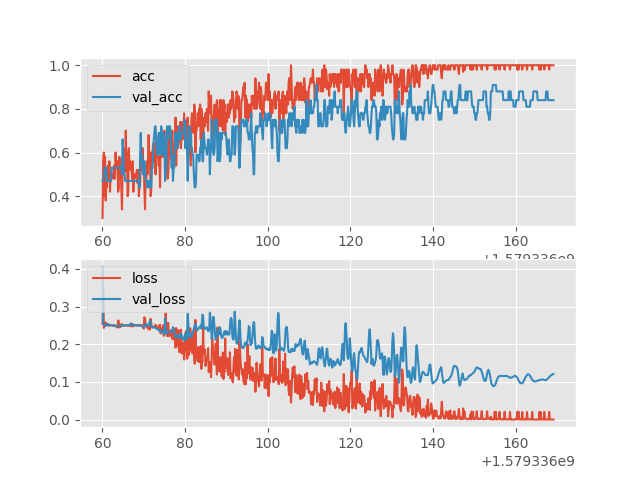

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

model_name = "model-1579336059" # grab whichever model name you want here. We could also just reference the MODEL_NAME if you're in a notebook still.


def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss, epoch = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))


    fig = plt.figure()

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times,losses, label="loss")
    ax2.plot(times,val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

create_acc_loss_graph(model_name)

# Validating/Testing Model

In [13]:
# moving testing tensors to the GPU if available
test_X.to(device)
test_y.to(device)

def test(net):
    correct = 0 
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))) :
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1,1,120,120).to(device))[0]
            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class :
                correct += 1
            total += 1

    print("Accuracy :", round(correct/total,3))
    
test(net)

100%|██████████| 203/203 [00:02<00:00, 86.32it/s]

Accuracy : 0.783


# Model starts training with low loss, accuracy is still low

High variance problem ? Model won't generalise due to lack of samples ? 


# Manual Validation

Check logic of manual validation function.

52


<IPython.core.display.Javascript object>


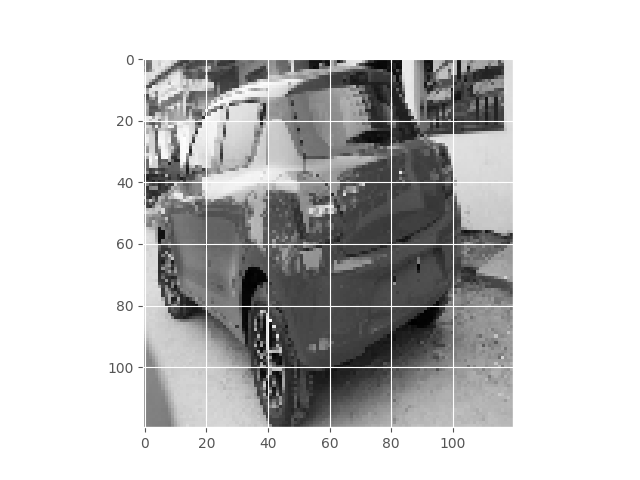

tensor(0, device='cuda:0')


In [14]:
%matplotlib notebook

## import matplotlib.pyplot as plt
#plt.imshow(X[2].view(50,50))

num = np.random.randint(203)
print(num)
plt.imshow(test_X[num].view(120,120), cmap = "gray")
plt.show()
net_out = net(test_X[num].view(-1,1,120,120).to(device))[0]
print(torch.argmax(net_out))

In [15]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

print('')
print('')
print('')

print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])
    
torch.save(net, 'checkpoint1_val.pt')


Model's state_dict:
conv1.weight 	 torch.Size([32, 1, 5, 5])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([64, 32, 5, 5])
conv2.bias 	 torch.Size([64])
conv3.weight 	 torch.Size([128, 64, 5, 5])
conv3.bias 	 torch.Size([128])
fc1.weight 	 torch.Size([512, 15488])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.Size([2, 512])
fc2.bias 	 torch.Size([2])



Optimizer's state_dict:
state 	 {139943011403888: {'step': 740, 'exp_avg': tensor([[[[-7.5106e-05, -6.3434e-05, -7.8959e-05, -8.8536e-05, -9.1839e-05],
          [-1.6158e-04, -1.6271e-04, -1.7299e-04, -1.9732e-04, -1.8529e-04],
          [-1.7341e-04, -1.6486e-04, -1.6519e-04, -1.6145e-04, -1.4833e-04],
          [-1.2762e-04, -1.1443e-04, -1.1531e-04, -1.1244e-04, -1.0461e-04],
          [-6.9903e-05, -4.9262e-05, -4.5129e-05, -5.5856e-05, -5.9850e-05]]],


        [[[ 1.0411e-05,  2.2529e-05,  2.2867e-05,  4.3546e-06,  3.9334e-06],
          [ 1.0245e-05,  3.6712e-05,  1.8992e-05,  1.8796e-05,  2.0633e-05],
          [ 2.

/home/desktop-anand/.local/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/desktop-anand/.local/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/desktop-anand/.local/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
